In [1]:
from sklearn.model_selection import train_test_split
import pickle
import os
import h5py
from PIL import Image
import numpy as np
import numpy as np
import math
import copy
import transforms3d
from tensorflow.keras.layers import Rescaling, Normalization, Input, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2024-10-15 21:53:47.753470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 21:53:47.771611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 21:53:47.777073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 21:53:47.791293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This 

In [2]:
input_dir = r"/work/nselva2s/robile_data_corr1"

In [24]:
# Load the dataset

def load_dataset(output_dir):
    # Define paths to your pickle files
    image_file = os.path.join(output_dir, 'images.h5')
    laser_file = os.path.join(output_dir, 'lasers.pkl')
    odom_file = os.path.join(output_dir, 'odoms.pkl')
    goal_odom_file = os.path.join(output_dir, 'goal_odoms.pkl')
    velocity_file = os.path.join(output_dir, 'velocities.pkl')
    tf_file = os.path.join(output_dir, 'tfs.pkl')
    
    # Load the pickle files
    with open(laser_file, 'rb') as f:
        lasers = pickle.load(f)
    with open(odom_file, 'rb') as f:
        current_poses = pickle.load(f)
    with open(goal_odom_file, 'rb') as f:
        goal_poses = pickle.load(f)
    with open(velocity_file, 'rb') as f:
        velocities = pickle.load(f)
    with open(tf_file, 'rb') as f:
        tfs = pickle.load(f)
    print('loading images')
    with h5py.File(image_file, 'r') as f:
        image_keys = list(f.keys())
        images = [Image.fromarray(f[key][:]) for key in image_keys]
    print('loaded images')
    # Split velocities into linear and angular components
    linear_velocities = np.array(velocities)[:, :2]  # Linear velocity (x, y)
    angular_velocities = np.array(velocities)[:, 2]  # Angular velocity (z)
    
    return  list(zip(images, lasers, current_poses, goal_poses, linear_velocities, angular_velocities, tfs))



data = load_dataset(input_dir)
print('loaded data')

loading images
loaded images
loaded data


In [25]:
import transforms3d

# Function to invert a transformation (translation + rotation)
def invert_transform(translation, rotation):
    # Convert the quaternion to a rotation matrix (3x3)
    rotation_matrix = transforms3d.quaternions.quat2mat([rotation[3], rotation[0], rotation[1], rotation[2]])[:3, :3]
    # Invert the rotation matrix (transpose of a rotation matrix is its inverse)
    rotation_matrix_inv = np.transpose(rotation_matrix)
    
    # Invert the translation (apply the inverse rotation to the negative translation)
    translation_inv = -np.dot(rotation_matrix_inv, [translation[0], translation[1], translation[2]])
    
    # Create the inverse quaternion (negate the vector part, keep the scalar part the same)
    rotation_inv = transforms3d.quaternions.qinverse([rotation[3], rotation[0], rotation[1], rotation[2]])
    return translation_inv, rotation_inv

# Function to apply the transformation (translation + rotation) to a point
def transform_point(translation, rotation, point):
    # Convert the point to a homogeneous vector (x, y, z, 1)
    point_homogeneous = np.array([point[0], point[1], point[2], 1.0])
    
    # Create the translation matrix (4x4)
    translation_matrix = np.identity(4)
    translation_matrix[0, 3] = translation[0]
    translation_matrix[1, 3] = translation[1]
    translation_matrix[2, 3] = translation[2]
    # Create the transformation matrix from translation and rotation
    rotation_matrix = np.identity(4)
    rotation_matrix[:3, :3] = transforms3d.quaternions.quat2mat(rotation)[:3, :3]
    # Combine translation and rotation into a single transformation matrix
    transformation_matrix = np.dot(translation_matrix, rotation_matrix)
    # Apply the transformation to the point
    transformed_point = np.dot(transformation_matrix, point_homogeneous)
    
    
    # Return the transformed point (x, y, z)
    return transformed_point[:3]

# Function to transform a point from odom to base_link frame
def transform_pose_to_base_link(translation, rotation, point_in_odom):
    # Get the inverse of the transformation
    translation_inv, rotation_inv = invert_transform(translation, rotation)
    
    # Convert the point from odom to base_link using the inverted transformation
    point_in_base_link = transform_point(translation_inv, rotation_inv, point_in_odom)
    
    return point_in_base_link

In [26]:
lasers = []
current_poses = []
goal_poses = []
linear_velocities = []
angular_velocities = []
tfs = []
images = []
goal = []
target_distance = 0.2

for i, (_, _, _, goal_pose1, _, _, _) in enumerate(data):
    for j, (image2, laser2, current_pose2, _, linear_velocity2, angular_velocity2, tf2) in enumerate(data[i:]):          
        distance = np.sqrt((goal_pose1[0] - current_pose2[0]) ** 2 + (goal_pose1[1] - current_pose2[1]) ** 2)
        if distance >= target_distance:
            goal_baselink = transform_pose_to_base_link(tf2[0], tf2[1], goal_pose1)
            goal_distance = distance
            goal_angle = math.atan2(goal_baselink[1],goal_baselink[0])
            goal.append([goal_distance, goal_angle])
            lasers.append(laser2)
            images.append(image2)
            current_poses.append(current_pose2)
            goal_poses.append(goal_pose1)
            linear_velocities.append(linear_velocity2)
            angular_velocities.append(angular_velocity2)
            tfs.append(tf2)
        else:
            break

In [27]:
print('get motion commands')
motion_commands = np.concatenate([np.expand_dims(np.array(linear_velocities)[:,0], axis=1), np.expand_dims(np.array(linear_velocities)[:,1], axis=1), np.expand_dims(angular_velocities, axis=1)], axis=1)  # Shape: (1000, 3)

get motion commands


In [ ]:
sampled_lasers = []
sampled_images = []
sampled_goals = []
sampled_motion_commands = []
num_bins = 10  # Number of bins
samples_per_bin = 29000  # Number of samples per bin

x = np.array(goal)[:,1]
# Create bins based on 'x' values
bins = np.linspace(x.min(), x.max(), num_bins + 1)  # Create bin edges

# Digitize the 'x' values to assign them to bins
bin_indices = np.digitize(x, bins)



# Sample uniformly from each bin
for i in range(1, num_bins + 1):
    # Get indices of data points in the current bin
    indices_in_bin = np.where(bin_indices == i)[0]
    
    if len(indices_in_bin) > 0:
        # Randomly sample from the bin
        sampled_indices = np.random.choice(indices_in_bin, size=min(samples_per_bin, len(indices_in_bin)), replace=True)
        sampled_lasers.extend(np.array(lasers)[sampled_indices])
        sampled_images.extend(np.array(images)[sampled_indices])
        sampled_goals.extend(np.array(goal)[sampled_indices])
        sampled_motion_commands.extend(np.array(motion_commands)[sampled_indices])

In [ ]:
tf_file = os.path.join(input_dir, 'sampled_dataset_withImages.tfrecord')

In [ ]:
# def serialize_example(laser, current_pose, goal_pose, goal, motion_command):
#     feature = {
#         # 'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
#         'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
#         'current_pose': tf.train.Feature(float_list=tf.train.FloatList(value=current_pose)),
#         'goal_pose': tf.train.Feature(float_list=tf.train.FloatList(value=goal_pose)),
#         'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
#         'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command))
#     }
#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

# def write_tfrecord(file_path, lasers, current_poses, goal_poses, goal, motion_commands):
#     with tf.io.TFRecordWriter(file_path) as writer:
#         for i in range(len(lasers)):
#             example = serialize_example(
#                 lasers[i], current_poses[i], goal_poses[i], goal[i], motion_commands[i]
#             )
#             writer.write(example)

# write_tfrecord(tf_file, lasers, current_poses, goal_poses, goal, motion_commands)
def serialize_example(image, laser, goal, motion_command):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
        'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
        'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(file_path, images, lasers, goal, motion_commands):
    with tf.io.TFRecordWriter(file_path) as writer:
        for i in range(len(lasers)):
            example = serialize_example(
                images[i], lasers[i], goal[i], motion_commands[i]
            )
            writer.write(example)

write_tfrecord(tf_file, sampled_images, sampled_lasers, sampled_goals, sampled_motion_commands)

In [4]:

# Define the parsing function
def _parse_function(proto):
    image_shape = [480, 640, 3]
    lasers_shape = 513  # Replace with the actual shape
    current_pose_shape = 3  # Replace with the actual shape
    goal_pose_shape = 3  # Replace with the actual shape
    motion_command_shape = 3  # Replace with the actual shape
    goal_shape = 2
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'laser': tf.io.FixedLenFeature([lasers_shape], tf.float32),
        # 'current_pose': tf.io.FixedLenFeature([current_pose_shape], tf.float32),
        # 'goal_pose': tf.io.FixedLenFeature([goal_pose_shape], tf.float32),
        'goal': tf.io.FixedLenFeature([goal_shape], tf.float32),
        'motion_command': tf.io.FixedLenFeature([motion_command_shape], tf.float32)
    }
    parsed_features = tf.io.parse_single_example(proto, features)
    image = tf.io.decode_jpeg(parsed_features['image'])
    image = tf.reshape(image, image_shape)
    # return (image, parsed_features['laser'], parsed_features['current_pose'], parsed_features['goal_pose']), parsed_features['motion_command']
    return  (image, parsed_features['laser'], parsed_features['goal']), parsed_features['motion_command']


# Load and parse the TFRecord dataset
def load_dataset(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count
    
def split_dataset(dataset, num_elements, train_size=0.7, val_size=0.2):
    # Compute split sizes
    train_end = int(train_size * num_elements)
    val_end = int((train_size + val_size) * num_elements)
    
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=num_elements, reshuffle_each_iteration=False)
    
    # Use tf.data.Dataset.take and skip to create splits
    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    # test_dataset = dataset.skip(val_end)
    test_dataset = dataset.skip(val_end).take(num_elements - val_end)
    
    return train_dataset, val_dataset, test_dataset

    # train_dataset = split_fn(dataset, 0, train_end)
    # val_dataset = split_fn(dataset, train_end, val_end)
    # test_dataset = split_fn(dataset, val_end, num_elements)
    
    # return train_dataset, val_dataset, test_dataset
    
# Preprocess and augment dataset
def replace_nan_inf(dataset, replacement_value=100.0):
    def replace_fn(features, labels):
        # Replace NaN and Inf in laser scans
        laser_scans = features[1]
        laser_scans = tf.where(tf.math.is_nan(laser_scans), replacement_value, laser_scans)
        laser_scans = tf.where(tf.math.is_inf(laser_scans), replacement_value, laser_scans)
        
        features = (laser_scans,features[2])
        return features, labels
    return dataset.map(replace_fn)
    
def preprocess_and_augment(dataset):
    dataset = replace_nan_inf(dataset)  # Apply NaN and Inf replacement
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(128)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset






In [7]:
# Load and preprocess the dataset
dataset = load_dataset(tf_file)

2024-10-15 21:54:12.163330: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
# Split the dataset
num_elements = count_elements(dataset)
train_dataset, val_dataset, test_dataset = split_dataset(dataset,num_elements)
# train_dataset, val_dataset, test_dataset = split_dataset(dataset,10000)


train_dataset = preprocess_and_augment(train_dataset)
val_dataset = preprocess_and_augment(val_dataset)
test_dataset = preprocess_and_augment(test_dataset)

print('Training, validation, and test datasets created and preprocessed.')

Training, validation, and test datasets created and preprocessed.


2024-10-15 21:55:08.181294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
num_elements/128

2265.625

## Models

### Laser and goal with res block

In [9]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input
import tensorflow as tf
from tensorflow.keras.layers import Dense, Rescaling, Normalization

# Define the normalization layers1
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()

def residual_block(x, units):
    """
    A residual block that adds a skip connection between the input and output of a dense block.
    
    :param x: Input to the block
    :param units: Number of units in the dense layers
    :return: Output after applying the residual block
    """
    # Shortcut connection (the original input)
    shortcut = x
    
    # Dense block with BatchNormalization and LeakyReLU
    x = Dense(units, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Ensure the input and output have the same dimensions before adding
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=HeNormal())(shortcut)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

def create_model(laser_shape, goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing laser scans, goals, and motion commands.

    :param laser_shape: Integer, size of the laser scans feature vector
    :param goal_shape: Integer, size of the goal feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = Input(shape=(laser_shape,), name='laser_input')
    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    
    # Goal processing with original layers and residual learning
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)
    goal_hidden = LeakyReLU()(goal_hidden)
    
    goal_hidden = residual_block(goal_hidden, 16)
    # goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)  # Original third layer
    # goal_hidden = BatchNormalization()(goal_hidden)
    # goal_hidden = LeakyReLU()(goal_hidden)

    # Laser processing with original layers and residual learning
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_normalized)
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = residual_block(laser_hidden, 64)
    # laser_hidden = Dense(64, kernel_initializer=HeNormal())(laser_hidden)  # Original third layer
    # laser_hidden = BatchNormalization()(laser_hidden)
    # laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = Dense(16, kernel_initializer=HeNormal())(laser_hidden)  # Original fourth layer
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)

    # Concatenate goal and laser processed features
    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden])
    
    # Further dense layers matching original architecture (128, 64, 16) with residuals
    hidden = Dense(128, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(64, kernel_initializer=HeNormal())(hidden)  # Original second dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)  # Original third dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    
    return model

# Define input shapes
laser_shape = 513            # Example laser scan feature size
goal_shape = 2               # Example goal feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 513)       │      1,027 │ laser_input[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,792 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         24 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ leaky_re_lu_3[0]… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │      1,040 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat

 Total params: 100,019 (390.71 KB)

 Trainable params: 98,107 (383.23 KB)

 Non-trainable params: 1,912 (7.48 KB)

### Laser and goal without res block

In [8]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
# Define the normalization layers
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()
def create_model(laser_shape,goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

    :param image_shape: Tuple, shape of the input images (height, width, channels)
    :param laser_shape: Integer, size of the laser scans feature vector
    :param pose_shape: Integer, size of the pose feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')

    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    
    # Dense layers to process goal distance and direction
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)
    goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)

    laser_hidden = laser_normalization(laser_normalized) 
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)
    laser_hidden = Dense(64, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)
    laser_hidden = Dense(16, kernel_initializer=HeNormal())(laser_hidden)
    laser_hidden = BatchNormalization()(laser_hidden)  # Add BatchNormalization
    laser_hidden = LeakyReLU()(laser_hidden)

    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden])
    
    hidden = Dense(64, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    hidden = Dense(16, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    
    

    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    

    
    return model
   
# Define input shapes
image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
laser_shape = 513            # Example laser scan feature size
pose_shape = 3   
goal_shape = 2  # Example pose feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 513)       │      1,027 │ laser_input[0][0… │
│ (Normalization)     │                   │            │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,792 │ normalization[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         24 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 77,859 (304.14 KB)

 Trainable params: 76,331 (298.17 KB)

 Non-trainable params: 1,528 (5.98 KB)

### goal without res block

In [17]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
# Define the normalization layers
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()
def create_model(laser_shape,goal_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

    :param image_shape: Tuple, shape of the input images (height, width, channels)
    :param laser_shape: Integer, size of the laser scans feature vector
    :param pose_shape: Integer, size of the pose feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')

    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    
    # Dense layers to process goal distance and direction
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)
    goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)
    goal_hidden = BatchNormalization()(goal_hidden)  # Add BatchNormalization
    goal_hidden = LeakyReLU()(goal_hidden)

    
    
    hidden = Dense(64, kernel_initializer=HeNormal())(goal_hidden)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)
    hidden = BatchNormalization()(hidden)  # Add BatchNormalization
    hidden = LeakyReLU()(hidden)
    
    

    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    

    
    return model
   
# Define input shapes
image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
laser_shape = 513            # Example laser scan feature size
pose_shape = 3   
goal_shape = 2  # Example pose feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ goal_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 2)         │          5 │ goal_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         24 │ normalization_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        144 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      1,088 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │      1,040 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ laser_input         │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motion_command_out… │ (None, 3)         │         51 │ leaky_re_lu_10[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,768 (10.82 KB)

 Trainable params: 2,555 (9.98 KB)

 Non-trainable params: 213 (856.00 B)

### Image, laser goal without res block

In [372]:
# # Import from tf.keras.layers without experimental
# from tensorflow.keras.layers import Rescaling, Normalization

# # Define the normalization layers
# image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
# laser_normalization = Normalization()  # Normalizes laser data
# pose_normalization = Normalization()   # Normalizes pose data

# def create_model(image_shape, laser_shape, pose_shape, motion_command_shape):
#     """
#     Creates a TensorFlow model for processing images, laser scans, poses, and motion commands.

#     :param image_shape: Tuple, shape of the input images (height, width, channels)
#     :param laser_shape: Integer, size of the laser scans feature vector
#     :param pose_shape: Integer, size of the pose feature vector
#     :param motion_command_shape: Integer, size of the motion command feature vector
#     :return: tf.keras.Model
#     """
   
#     # Input layers
#     image_input = tf.keras.layers.Input(shape=image_shape, name='image_input')
#     laser_input = tf.keras.layers.Input(shape=(laser_shape,), name='laser_input')
#     current_pose_input = tf.keras.layers.Input(shape=(pose_shape,), name='current_pose_input')
#     goal_pose_input = tf.keras.layers.Input(shape=(pose_shape,), name='goal_pose_input')
    
#     # Convolutional layers for image processing
#     image = image_rescaling(image_input)
#     x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.Flatten()(x)  # Flatten to 1D
    
#     # Dense layers for laser scans and poses
#     laser = laser_normalization(laser_input)
#     laser_dense = tf.keras.layers.Dense(64, activation='relu')(laser)    
#     current_pose = pose_normalization(current_pose_input)
#     goal_pose = pose_normalization(goal_pose_input)
#     current_pose_dense = tf.keras.layers.Dense(64, activation='relu')(current_pose_input)
#     goal_pose_dense = tf.keras.layers.Dense(64, activation='relu')(goal_pose)
    
#     # Concatenate all features
#     concatenated = tf.keras.layers.concatenate([x, laser_dense, current_pose_dense, goal_pose_dense])
    
#     # Dense layers for final processing
#     hidden = tf.keras.layers.Dense(128, activation='relu')(concatenated)
#     hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
    
#     # Output layer
#     output = tf.keras.layers.Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
#     # Create model
#     model = tf.keras.Model(inputs=[image_input, laser_input, current_pose_input, goal_pose_input],
#                            outputs=output)
    
#     # Compile model
#     model.compile(optimizer='adam',
#                   loss='mse',
#                   metrics=['mae'])
    
#     return model

# # Define input shapes
# image_shape = (480, 640, 3)  # Example image shape (height, width, channels)
# laser_shape = 513            # Example laser scan feature size
# pose_shape = 3               # Example pose feature size
# motion_command_shape = 3     # Example motion command size

# # Create and summarize the model
# model = create_model(image_shape, laser_shape, pose_shape, motion_command_shape)
# model.summary()

### image, laser, goal with res block

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Rescaling, Normalization, Conv2D, MaxPooling2D

# Define the normalization layers1
image_rescaling = Rescaling(1./255)  # Rescale pixel values to [0, 1]
laser_normalization = Normalization()  # Normalizes laser data
goal_normalization = Normalization()

def residual_block(x, units):
    """
    A residual block that adds a skip connection between the input and output of a dense block.
    
    :param x: Input to the block
    :param units: Number of units in the dense layers
    :return: Output after applying the residual block
    """
    # Shortcut connection (the original input)
    shortcut = x
    
    # Dense block with BatchNormalization and LeakyReLU
    x = Dense(units, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Ensure the input and output have the same dimensions before adding
    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=HeNormal())(shortcut)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

def create_model(laser_shape, goal_shape, image_shape, motion_command_shape):
    """
    Creates a TensorFlow model for processing laser scans, goals, and motion commands.

    :param laser_shape: Integer, size of the laser scans feature vector
    :param goal_shape: Integer, size of the goal feature vector
    :param motion_command_shape: Integer, size of the motion command feature vector
    :return: tf.keras.Model
    """

    goal_input = Input(shape=(goal_shape,), name='goal_input')
    laser_input = Input(shape=(laser_shape,), name='laser_input')
    image_input = Input(shape=(image_shape,), name='image_input')
    
    # Optional normalization
    goal_normalized = goal_normalization(goal_input)
    laser_normalized = laser_normalization(laser_input)
    image_rescaled = image_rescaling(image_input) 
    
    # Goal processing with original layers and residual learning
    goal_hidden = Dense(8, kernel_initializer=HeNormal())(goal_normalized)
    goal_hidden = BatchNormalization()(goal_hidden)
    goal_hidden = LeakyReLU()(goal_hidden)
    
    goal_hidden = residual_block(goal_hidden, 16)
    # goal_hidden = Dense(16, kernel_initializer=HeNormal())(goal_hidden)  # Original third layer
    # goal_hidden = BatchNormalization()(goal_hidden)
    # goal_hidden = LeakyReLU()(goal_hidden)

    # Laser processing with original layers and residual learning
    laser_hidden = Dense(128, kernel_initializer=HeNormal())(laser_normalized)
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = residual_block(laser_hidden, 64)
    # laser_hidden = Dense(64, kernel_initializer=HeNormal())(laser_hidden)  # Original third layer
    # laser_hidden = BatchNormalization()(laser_hidden)
    # laser_hidden = LeakyReLU()(laser_hidden)
    
    laser_hidden = Dense(16, kernel_initializer=HeNormal())(laser_hidden)  # Original fourth layer
    laser_hidden = BatchNormalization()(laser_hidden)
    laser_hidden = LeakyReLU()(laser_hidden)

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_rescaled)
    base_model.trainable = False  # Freeze the pretrained layers
    
    # Process image features
    image_hidden = base_model.output
    image_hidden = Flatten()(image_hidden)  # Flatten the output
    
    # Custom dense layers to reduce feature size
    image_hidden = Dense(16, kernel_initializer='he_normal')(image_hidden)
    image_hidden = BatchNormalization()(image_hidden)
    image_hidden = LeakyReLU()(image_hidden)

    # image_hidden = Conv2D(32, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_rescaled)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(64, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Conv2D(128, (3, 3), kernel_initializer=HeNormal(), activation=None)(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)
    # image_hidden = MaxPooling2D(pool_size=(2, 2))(image_hidden)
    
    # image_hidden = Flatten()(image_hidden)  # Flatten the output from the convolutional layers
    
    # # Reduce the flattened vector to size 16
    # image_hidden = Dense(16, kernel_initializer=HeNormal())(image_hidden)
    # image_hidden = BatchNormalization()(image_hidden)
    # image_hidden = LeakyReLU()(image_hidden)

    # Concatenate goal and laser processed features
    concatenated = tf.keras.layers.concatenate([goal_hidden, laser_hidden, image_hidden])
    
    # Further dense layers matching original architecture (128, 64, 16) with residuals
    hidden = Dense(128, kernel_initializer=HeNormal())(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(64, kernel_initializer=HeNormal())(hidden)  # Original second dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    hidden = Dense(16, kernel_initializer=HeNormal())(hidden)  # Original third dense layer
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    
    # Output layer for linear and angular velocities
    output = Dense(motion_command_shape, activation='linear', name='motion_command_output')(hidden)
    
    # Create model
    model = Model(inputs=[laser_input, goal_input], outputs=output)
    
    return model

# Define input shapes
laser_shape = 513            # Example laser scan feature size
goal_shape = 2               # Example goal feature size
motion_command_shape = 3     # Example motion command size

# Create and summarize the model
model = create_model(laser_shape, goal_shape, motion_command_shape)
model.summary()


## Training

In [10]:
from tensorflow.keras.callbacks import Callback
class PrintLearningRateCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        # Evaluate the learning rate if it's a schedule
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"\nEpoch {epoch+1}: Learning rate is {tf.keras.backend.eval(lr)}")


In [12]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an exponential decay learning rate schedule
initial_learning_rate = 0.05
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=2000,  # Number of steps before decaying
    decay_rate=0.8,    # Decay rate
    staircase=True      # Apply decay at discrete intervals
)

# Compile the model with the optimizer that uses the schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [13]:
history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
    steps_per_epoch=500,  # Number of steps per epoch
    validation_steps=100,
        verbose=1,
    callbacks=[PrintLearningRateCallback()]
    )

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0272 - mae: 0.0455
Epoch 1: Learning rate is 0.05000000074505806
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0272 - mae: 0.0455 - val_loss: 3.7764e-05 - val_mae: 0.0045
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7695e-05 - mae: 0.0031
Epoch 2: Learning rate is 0.05000000074505806
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.7692e-05 - mae: 0.0031 - val_loss: 1.0742e-05 - val_mae: 0.0024
Epoch 3/200
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3207e-05 - mae: 0.0027
Epoch 3: Learning rate is 0.05000000074505806
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.3208e-05 - mae: 0.0027 - val_loss: 1.8581e-05 - val_mae: 0.0032
Epoch 4/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.2167e-05 - mae: 0.0026

2024-10-15 21:58:06.977523: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib64/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 4: Learning rate is 0.05000000074505806
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1449e-05 - mae: 0.0025 - val_loss: 1.4941e-05 - val_mae: 0.0029
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2162e-05 - mae: 0.0026
Epoch 5: Learning rate is 0.04000000283122063
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.2162e-05 - mae: 0.0026 - val_loss: 1.0966e-05 - val_mae: 0.0024
Epoch 6/200
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0963e-05 - mae: 0.0024
Epoch 6: Learning rate is 0.04000000283122063
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 1.0971e-05 - mae: 0.0024 - val_loss: 2.1055e-05 - val_mae: 0.0036
Epoch 7/200
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6791e-05 - mae: 0.0029
Epoch 7: Learning rate is 0.04000000283122063
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.6777e-05 - mae: 0.0029 - val_loss: 1.0849e-05 - val_mae: 0.0024
Epoch 8/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.4098e-05 - mae: 0.0027

2024-10-15 21:58:37.149585: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: Learning rate is 0.04000000283122063
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6442e-05 - mae: 0.0029 - val_loss: 9.0885e-06 - val_mae: 0.0022
Epoch 9/200
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3651e-05 - mae: 0.0027
Epoch 9: Learning rate is 0.04000000283122063
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.3657e-05 - mae: 0.0027 - val_loss: 1.7466e-05 - val_mae: 0.0029
Epoch 10/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5144e-05 - mae: 0.0028
Epoch 10: Learning rate is 0.03200000151991844
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.5142e-05 - mae: 0.0028 - val_loss: 9.0576e-06 - val_mae: 0.0021
Epoch 11/200
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2546e-05 - mae: 0.0026
Epoch 11: Learning rate is 0.03200000151991844
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 1.2546e-05 - mae: 0.0026 - val_loss: 1.0735e-05 - val_mae: 0.0025
Epoch 12/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.2031e-05 - mae: 0.0026


2024-10-15 21:59:29.166524: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: Learning rate is 0.025600001215934753
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.0983e-05 - mae: 0.0024 - val_loss: 1.3267e-05 - val_mae: 0.0026
Epoch 17/200
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1043e-05 - mae: 0.0024
Epoch 17: Learning rate is 0.025600001215934753
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.1048e-05 - mae: 0.0024 - val_loss: 1.3367e-05 - val_mae: 0.0028
Epoch 18/200
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0353e-05 - mae: 0.0024
Epoch 18: Learning rate is 0.025600001215934753
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0356e-05 - mae: 0.0024 - val_loss: 1.1609e-05 - val_mae: 0.0025
Epoch 19/200
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0682e-05 - mae: 0.0024
Epoch 19: Learning rate is 0.025600001215934753
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0682e-05 - mae: 0.0024 - val_loss: 1.0865e-05 - val_mae: 0.0026
Epoch 20/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0770e-05 - mae: 

2024-10-15 22:01:49.221016: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 86/500 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2722e-06 - mae: 0.0013
Epoch 36: Learning rate is 0.010485760867595673
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 4.7326e-06 - mae: 0.0014 - val_loss: 5.5421e-06 - val_mae: 0.0016
Epoch 37/200
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9755e-06 - mae: 0.0013
Epoch 37: Learning rate is 0.010485760867595673
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 3.9754e-06 - mae: 0.0013 - val_loss: 2.9599e-06 - val_mae: 0.0011
Epoch 38/200
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0290e-06 - mae: 0.0013
Epoch 38: Learning rate is 0.010485760867595673
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.0283e-06 - mae: 0.0013 - val_loss: 3.0520e-06 - val_mae: 0.0011
Epoch 39/200
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9358e-06 - mae: 0.0013
Epoch 39: Learning rate is 0.010485760867595673
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9361e-06 - mae: 0.0013 - val_loss: 3.1828e-06 - val_mae: 0.0011
Epoch 4

2024-10-15 22:05:46.773209: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0837e-06 - mae: 9.0461e-04
Epoch 71: Learning rate is 0.0021990237291902304
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 2.0838e-06 - mae: 9.0460e-04 - val_loss: 1.3797e-06 - val_mae: 6.9953e-04
Epoch 72/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.8725e-06 - mae: 8.4888e-04
Epoch 72: Learning rate is 0.0021990237291902304
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0024e-06 - mae: 8.7878e-04 - val_loss: 1.5161e-06 - val_mae: 7.3798e-04
Epoch 73/200
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9390e-06 - mae: 8.6845e-04
Epoch 73: Learning rate is 0.0021990237291902304
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.9393e-06 - mae: 8.6855e-04 - val_loss: 1.6263e-06 - val_mae: 7.9058e-04
Epoch 74/200
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1044e-06 - mae: 8.9945e-04
Epoch 74: Learning rate is 0.0021990237291902304
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.1044e-06 - mae: 8.9946e-04 -

2024-10-15 22:13:36.374295: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5052e-06 - mae: 7.5692e-04
Epoch 141: Learning rate is 9.671410953160375e-05
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 1.5054e-06 - mae: 7.5694e-04 - val_loss: 1.1398e-06 - val_mae: 6.3341e-04
Epoch 142/200
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5610e-06 - mae: 7.6086e-04
Epoch 142: Learning rate is 9.671410953160375e-05
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.5611e-06 - mae: 7.6087e-04 - val_loss: 1.1156e-06 - val_mae: 6.2173e-04
Epoch 143/200
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5310e-06 - mae: 7.6252e-04
Epoch 143: Learning rate is 9.671410953160375e-05
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.5313e-06 - mae: 7.6255e-04 - val_loss: 1.1575e-06 - val_mae: 6.2215e-04
Epoch 144/200
 86/500 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.6630e-06 - mae: 7.7948e-04
Epoch 144: Learning rate is 9.671410953160375e-05
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6428e-06 - mae: 7.7409e

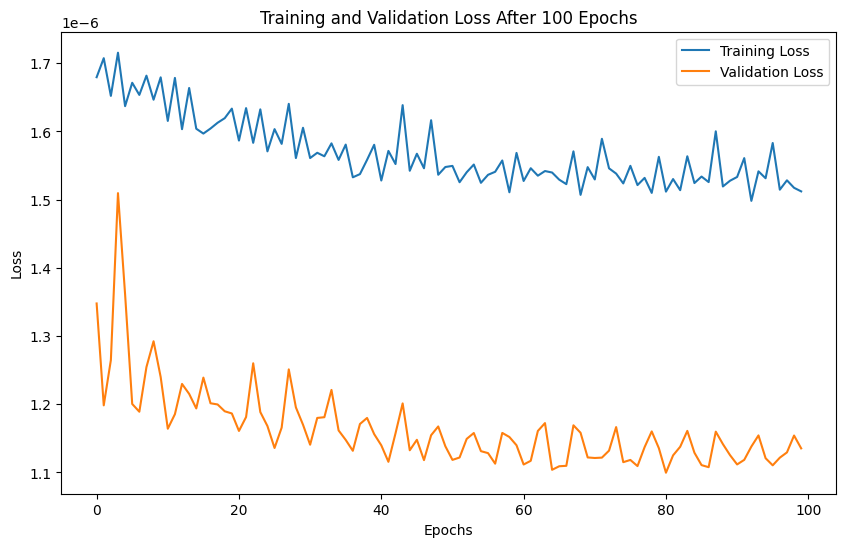

In [15]:
import matplotlib.pyplot as plt

# Specify after how many epochs you want to plot
n_epochs = 100  # Change this value to the number of epochs you're interested in

plt.figure(figsize=(10, 6))

# Plot training loss after 'n_epochs'
plt.plot(history.history['loss'][n_epochs:], label='Training Loss')

# Plot validation loss after 'n_epochs'
plt.plot(history.history['val_loss'][n_epochs:], label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss After {n_epochs} Epochs')
plt.legend()

# Show the plot
plt.show()

In [16]:
# Evaluate the model
test_loss = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")

227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1078e-06 - mae: 6.0965e-04
Test Loss: [1.097017388929089e-06, 0.0006093820556998253]


/usr/lib64/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [18]:
model_file = os.path.join(input_dir, 'goal_laser_res_200epochs.keras')
model.save(model_file)

In [19]:
single_data_point = next(iter(test_dataset.take(1)))


In [20]:
model.predict(single_data_point[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


array([[-3.57870478e-04, -7.55503424e-05, -6.76483428e-03],
       [ 1.74557790e-05,  4.95596687e-05,  4.77693742e-03],
       [ 1.60722993e-04, -1.18459131e-04, -9.33937728e-03],
       [ 2.50209123e-05,  1.54756242e-04,  7.80963339e-03],
       [ 7.70703284e-03, -4.61861055e-05, -5.67054981e-03],
       [ 7.88510777e-03, -3.86861066e-05, -7.02236360e-03],
       [ 8.22592527e-03, -3.27064554e-05, -2.19200738e-05],
       [ 7.71219330e-03,  7.35077338e-05,  6.28755847e-03],
       [ 7.69417221e-03,  3.12278935e-05,  5.94647136e-04],
       [-1.58164185e-04, -5.58817992e-05, -6.35891361e-03],
       [ 7.74141820e-03,  2.73606529e-05,  6.28223643e-05],
       [-1.39324926e-04,  7.53903878e-05,  9.08313692e-03],
       [ 7.67042721e-03, -6.76384880e-05, -4.71868878e-03],
       [ 7.94466399e-03,  2.02925803e-05, -6.62446162e-03],
       [ 8.45665764e-03, -2.94882211e-05,  4.49921936e-06],
       [-9.45217907e-05,  5.07018849e-05,  6.67387713e-03],
       [ 7.28528434e-03,  1.40224482e-04

In [21]:
single_data_point[0]

(<tf.Tensor: shape=(128, 513), dtype=float32, numpy=
 array([[1.698, 1.698, 1.698, ..., 1.631, 1.636, 1.637],
        [1.425, 1.426, 1.432, ..., 2.519, 2.52 , 2.532],
        [2.642, 2.639, 2.628, ..., 0.854, 0.854, 0.856],
        ...,
        [2.99 , 2.985, 2.971, ..., 0.55 , 0.547, 0.546],
        [0.459, 0.459, 0.459, ..., 0.598, 0.598, 0.598],
        [2.472, 2.472, 2.474, ..., 1.56 , 1.564, 1.575]], dtype=float32)>,
 <tf.Tensor: shape=(128, 2), dtype=float32, numpy=
 array([[ 9.80830967e-01, -8.97198617e-01],
        [ 9.58544850e-01,  1.28848708e+00],
        [ 9.48573887e-01, -5.15028238e-01],
        [ 5.02870500e-01,  8.10257256e-01],
        [ 6.12736583e-01, -2.53182501e-01],
        [ 7.52270520e-01, -2.49956787e-01],
        [ 5.23104548e-01, -9.52011347e-01],
        [ 8.83713305e-01,  7.83039212e-01],
        [ 3.64592612e-01, -1.32295318e-04],
        [ 1.00071454e+00, -6.47200227e-01],
        [ 8.31767023e-01,  1.26418948e-01],
        [ 3.58013362e-01,  4.54501241e-

In [22]:
single_data_point[1]

<tf.Tensor: shape=(128, 3), dtype=float32, numpy=
array([[ 1.77587322e-06,  4.34734193e-06, -7.64890620e-03],
       [ 2.09867474e-04, -3.01300988e-05,  4.12092777e-03],
       [ 1.58776878e-04, -1.34073154e-04, -8.06637388e-03],
       [ 5.61765664e-05,  3.43668828e-04,  8.36087111e-03],
       [ 6.80673262e-03,  2.87352141e-05, -5.17882733e-03],
       [ 8.72962084e-03,  1.52047812e-06, -6.89340336e-03],
       [ 7.22957682e-03, -9.64381070e-06, -1.51410743e-04],
       [ 8.46165512e-03,  5.00122434e-04,  6.66330848e-03],
       [ 8.98150727e-03, -2.13287831e-06,  1.99847127e-04],
       [ 2.66917232e-05,  1.38969026e-05, -6.11887360e-03],
       [ 6.41517667e-03, -1.94865643e-05,  2.31377868e-04],
       [ 6.25269313e-04,  2.06126148e-04,  1.19621521e-02],
       [ 8.48679990e-03, -8.60071625e-04, -5.93273016e-03],
       [ 9.48340725e-03,  1.56174166e-04, -7.97159784e-03],
       [ 8.03487469e-03, -2.58351247e-05,  1.77564434e-05],
       [-2.45123883e-05, -5.12707702e-05,  8.18668

In [20]:
# to check input shapes
def print_input_shapes(x):
    print(x)
    print(f"Input shape: {x[0].shape}")
    return x

# Apply this to the data pipeline
train_dataset = train_dataset.map(lambda x, y: (print_input_shapes(x), y))
val_dataset = val_dataset.map(lambda x, y: (print_input_shapes(x), y))

(<tf.Tensor 'args_0:0' shape=(None, None, None, None) dtype=uint8>, <tf.Tensor 'args_1:0' shape=(None, 513) dtype=float32>, <tf.Tensor 'args_2:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'args_3:0' shape=(None, 3) dtype=float32>)
Input shape: (None, None, None, None)
(<tf.Tensor 'args_0:0' shape=(None, None, None, None) dtype=uint8>, <tf.Tensor 'args_1:0' shape=(None, 513) dtype=float32>, <tf.Tensor 'args_2:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'args_3:0' shape=(None, 3) dtype=float32>)
Input shape: (None, None, None, None)


In [23]:
np.histogram(np.array(sampled_goals)[:,1], bins=10)


(array([28993, 28974, 28975, 28986, 29035, 28998, 28996, 29004, 28935,
        29104]),
 array([-1.2581576 , -0.99767751, -0.73719741, -0.47671732, -0.21623723,
         0.04424286,  0.30472295,  0.56520305,  0.82568314,  1.08616323,
         1.34664332]))

In [21]:
sampled_goals

[array([[ 1.00419323, -1.22763559],
        [ 1.00071485, -1.03395393],
        [ 1.00419321, -1.22763547],
        ...,
        [ 0.85698663, -1.14172893],
        [ 1.00419342, -1.22763517],
        [ 0.98073481, -1.03843398]]),
 array([[ 0.82053627, -0.87260893],
        [ 0.95389877, -0.77188128],
        [ 0.98083811, -0.92169868],
        ...,
        [ 0.94613826, -0.83914481],
        [ 0.90998324, -0.82348975],
        [ 0.98221886, -0.90271836]]),
 array([[ 0.45783399, -0.48434394],
        [ 0.97210977, -0.68879425],
        [ 0.95022508, -0.58250519],
        ...,
        [ 1.00068143, -0.73056639],
        [ 0.56672815, -0.56055738],
        [ 1.00070779, -0.61370171]]),
 array([[ 1.0035223 , -0.32578407],
        [ 0.77985722, -0.24757547],
        [ 0.8579159 , -0.25880823],
        ...,
        [ 0.42917139, -0.3101461 ],
        [ 0.8943504 , -0.3462869 ],
        [ 0.34927315, -0.32904911]]),
 array([[ 0.5006433 , -0.20746913],
        [ 0.85167122,  0.03173292],
    

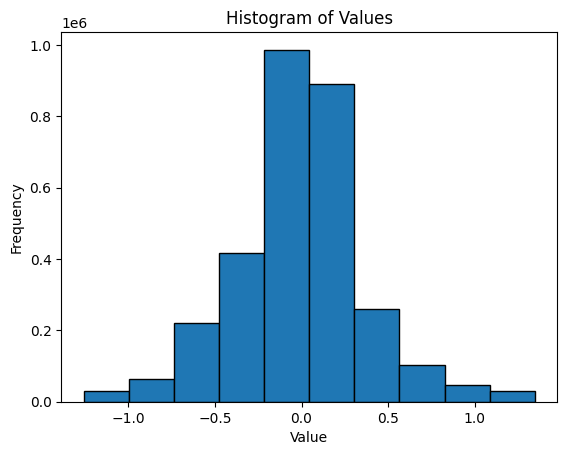

In [8]:
import matplotlib.pyplot as plt
plt.hist(np.array(goal)[:,1], bins=10, edgecolor='black')  # Adjust the number of bins as necessary
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


In [4]:
! pip install git+https://github.com/ros/geometry.git#subdirectory=tf_conversions

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ros/geometry.git to /tmp/pip-req-build-u10806m4
  Running command git clone -q https://github.com/ros/geometry.git /tmp/pip-req-build-u10806m4
  Resolved https://github.com/ros/geometry.git to commit fe344b6c848b8239750ad7f8c7eccf86241396d3
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-u10806m4/tf_conversions/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-u10806m4/tf_conversions/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-zaa887_y
         cwd: /tmp/pip-req-build-u10806m4/tf_conversions
    Compl